In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

# Get Data

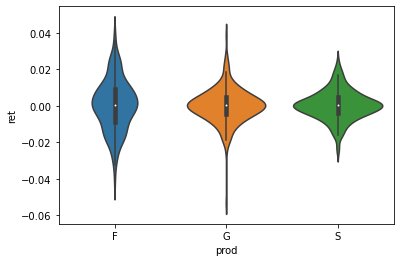

In [15]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()


# Combine Seperate DFs into one
combined_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    combined_df = pd.concat([combined_df , v[["ret","dir","prod"]]] , axis = 0)
    
# Visualize Data
sns.violinplot(x='prod', y='ret', data=combined_df)

,F,G,S
2012-01-04 00:00:00,-0.014730,0.005067,0.001569
2012-01-05 00:00:00,0.006770,0.006828,0.002662
2012-01-06 00:00:00,-0.014570,-0.003676,-0.002577
2012-01-09 00:00:00,0.021325,-0.004453,0.002427
2012-01-10 00:00:00,0.022550,0.013674,0.008671


Text(0.5, 1.0, 'G VS S')

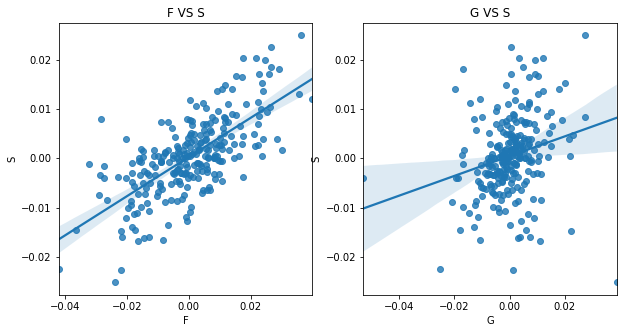

In [24]:
ret_df = pd.DataFrame()
for k , v in data.items():
    ret_df = pd.concat([ret_df , v["ret"]], axis = 1)
ret_df.columns = data.keys()
display(ret_df.head())

_ , ax = plt.subplots(1, 2, figsize=(10, 5))
sns.regplot(x = "F" , y = "S", data = ret_df , ax = ax[0]).set_title("F VS S")
sns.regplot(x = "G" , y = "S", data = ret_df , ax = ax[1]).set_title("G VS S")

In [32]:
X = ret_df[["F","G"]].values
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = ret_df["S"].values

# Multiple Regression

In [33]:
with pm.Model() as model_mlr:
    intercept_tmp = pm.Normal('intercept_tmp', mu=0, sd=10)
    slope = pm.Normal('slope', mu=0, sd=1, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = intercept_tmp + pm.math.dot(X_centered, slope)

    intercept = pm.Deterministic('intercept', intercept_tmp - pm.math.dot(X_mean, slope))

    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, intercept_tmp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:06<00:00, 799.69draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept[0],0.000,0.000,-0.000,0.001,0.000,0.0,5533.0,2989.0,5537.0,3342.0,1.0
slope[0],0.391,0.028,0.341,0.445,0.000,0.0,3329.0,3305.0,3335.0,2919.0,1.0
slope[1],0.031,0.041,-0.043,0.109,0.001,0.0,3462.0,3416.0,3468.0,3154.0,1.0
sigma,0.006,0.000,0.005,0.006,0.000,0.0,3896.0,3873.0,3891.0,3265.0,1.0


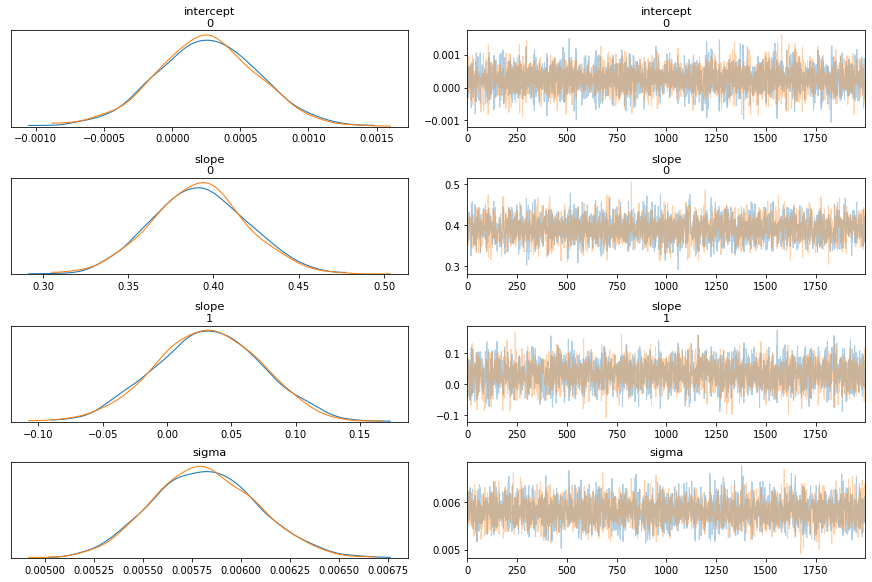

In [42]:
varnames = ['intercept', 'slope', 'sigma']
az.plot_trace(trace_mlr, var_names=varnames);
az.summary(trace_mlr, var_names=varnames)

# Check multicollinearity
    - Wide HPD , strong linear corr

array([<matplotlib.axes._subplots.AxesSubplot object at 0x127279f50>],
      dtype=object)

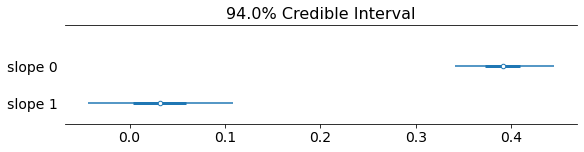

In [43]:
az.plot_forest(trace_mlr, var_names=['slope'], combined=True, figsize=(8, 2))

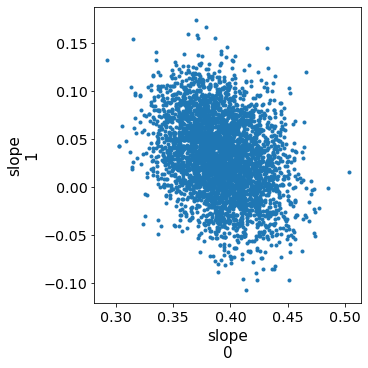

In [44]:
az.plot_pair(trace_mlr, var_names=['slope'], figsize=(5, 5))

# Confounding / Redundant / Masking Effects

In [35]:
# Create 3 modesl, with x1 x2 , x1 only and x2 only
with pm.Model() as m_x1x2:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    beta_2 = pm.Normal('beta_2', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = intercept + beta_1 * X[:, 0] + beta_2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = intercept + beta_1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta_2 = pm.Normal('beta_2', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = intercept + beta_2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_2, beta_1, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:07<00:00, 656.12draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_1, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:06<00:00, 743.50draws/s] 
The acceptance probability does not match the target. It is 0.8958598445841314, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967467915280178, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_2, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████|

array([<matplotlib.axes._subplots.AxesSubplot object at 0x126bd0610>],
      dtype=object)

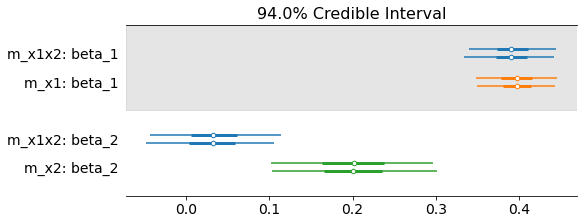

In [36]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['beta_1', 'beta_2'],
               combined=False, colors='cycle', figsize=(8, 3))

# Interaction 

In [61]:
x1_x2 = np.multiply( X[:, 0] , X[:, 1])
with pm.Model() as m_interaction:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    beta_2 = pm.Normal('beta_2', mu=0, sd=10)
    beta_3 = pm.Normal('beta_3', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 5)

    mu = intercept + beta_1 * X[:, 0] + beta_2 * X[:, 1] +  beta_3 * x1_x2

    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y)

    trace_interaction = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_3, beta_2, beta_1, intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 412.47draws/s] 
The acceptance probability does not match the target. It is 0.884669462560448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834547781965004, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,0.000,0.000,-0.001,0.001,0.000,0.000,4256.0,2343.0,4257.0,3431.0,1.0
beta_1,0.390,0.027,0.338,0.439,0.000,0.000,4155.0,4150.0,4163.0,3022.0,1.0
beta_2,0.037,0.040,-0.043,0.107,0.001,0.001,3583.0,3041.0,3589.0,3308.0,1.0
beta_3,5.742,2.138,1.804,9.892,0.033,0.024,4136.0,3956.0,4125.0,3251.0,1.0
sigma,0.006,0.000,0.005,0.006,0.000,0.000,4378.0,4344.0,4421.0,3121.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c01a690>,
      dtype=object)

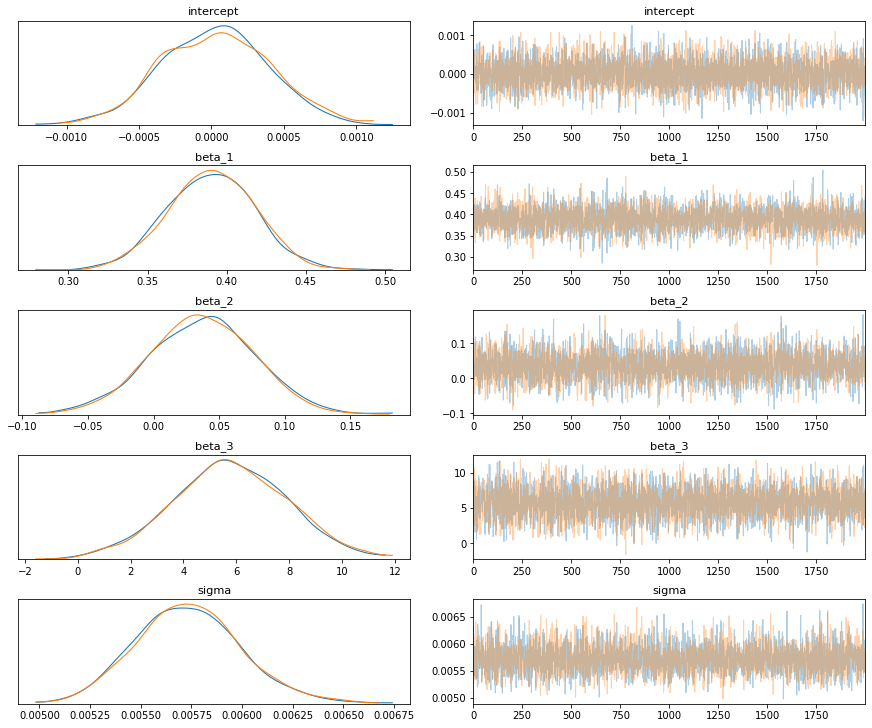

In [66]:
display(az.summary(trace_interaction))
az.plot_trace(trace_interaction)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x128cbaad0>],
      dtype=object)

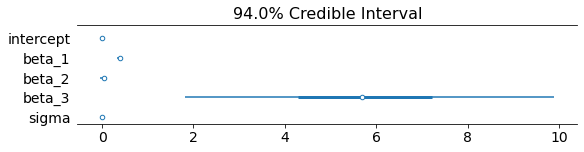

In [67]:
az.plot_forest(trace_interaction, combined=True, figsize=(8, 2))